In [27]:
import pandas as pd

# 엑셀 파일 불러오기
df = pd.read_excel(r'C:\Users\speec\OneDrive\Desktop\PoC_v2\data\WDPL_all_issues_with_P.xlsx')

# 삭제할 컬럼 리스트
cols_to_drop = [
    'c_0_3', 'c_3_6', 'c_6_9',
    'er_0_3', 'er_3_6', 'er_6_9',
    'R', 'mu_R', 'std_R', 'P_z'
]

# 해당 컬럼들 삭제 (존재하는 경우만)
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

df = df.dropna(subset=['D'])

# P 컬럼의 값이 "FlagP"인 경우 "Pflag"로 변경
df.loc[df['P'] == 'FlagP', 'P'] = 'Pflag'

# info 출력 및 추가적으로 저장
df.info()
df.to_excel(r'C:\Users\speec\OneDrive\Desktop\PoC_v2\data\WDPL_all_issues_with_P_processed.xlsx', index=False)


C:\Users\speec\AppData\Local\Temp\ipykernel_9764\1680776092.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Pflag' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df['P'] == 'FlagP', 'P'] = 'Pflag'


<class 'pandas.core.frame.DataFrame'>
Index: 1324 entries, 1 to 1354
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   issue           1324 non-null   object        
 1   datetime_3h     1324 non-null   datetime64[ns]
 2   channel         1324 non-null   object        
 3   viewCount       1324 non-null   int64         
 4   likeCount       1324 non-null   int64         
 5   comment_cnt     1324 non-null   int64         
 6   aligned_cnt_3h  1324 non-null   int64         
 7   aligned_cnt_6h  1324 non-null   int64         
 8   aligned_cnt_9h  1324 non-null   int64         
 9   match_sum       1324 non-null   int64         
 10  Entity          1324 non-null   int64         
 11  Event           1324 non-null   int64         
 12  Cause           1324 non-null   int64         
 13  Impact          1324 non-null   int64         
 14  Reaction        1324 non-null   int64         
 15  Lflag    

In [28]:
df.columns
df = df.fillna(0)

C:\Users\speec\AppData\Local\Temp\ipykernel_9764\2871171657.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1324 entries, 1 to 1354
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   issue           1324 non-null   object        
 1   datetime_3h     1324 non-null   datetime64[ns]
 2   channel         1324 non-null   object        
 3   viewCount       1324 non-null   int64         
 4   likeCount       1324 non-null   int64         
 5   comment_cnt     1324 non-null   int64         
 6   aligned_cnt_3h  1324 non-null   int64         
 7   aligned_cnt_6h  1324 non-null   int64         
 8   aligned_cnt_9h  1324 non-null   int64         
 9   match_sum       1324 non-null   int64         
 10  Entity          1324 non-null   int64         
 11  Event           1324 non-null   int64         
 12  Cause           1324 non-null   int64         
 13  Impact          1324 non-null   int64         
 14  Reaction        1324 non-null   int64         
 15  Lflag    

In [30]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# -----------------------------
# 1) 채널별 데이터 분리 함수
# -----------------------------
def make_dataset(df, features, target, window_size=6):
    data = df[features + [target]].values
    
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, :-1])
        y.append(data[i+window_size, -1])
    return np.array(X), np.array(y)


# -----------------------------
# 2) LSTM 학습 함수
# -----------------------------
def train_lstm_for_channel(df, channel_name, window_size=6):

    print(f"===== {channel_name} 채널 모델 학습 시작 =====")

    df_ch = df[df["channel"] == channel_name].sort_values("datetime_3h").reset_index(drop=True)

    # 타깃값 로그변환 (추천)
    df_ch["log_C"] = np.log1p(df_ch["C_cur"])

    # 사용할 feature 리스트 (df 컬럼 그대로)
    features = [
        'match_sum', 'Entity', 'Event', 'Cause', 'Impact', 'Reaction', 'Lflag',
        'abs_sent_gap', 'D', 'Lnorm', 'W', 'W_norm', 'FlagP', 'P',
        'aligned_cnt_3h', 'aligned_cnt_6h', 'aligned_cnt_9h'
    ]

    target = "log_C"

    # 스케일러 적용
    scaler = MinMaxScaler()
    df_ch[features + [target]] = scaler.fit_transform(df_ch[features + [target]])

    # dataset 생성
    X, y = make_dataset(df_ch, features, target, window_size)
    X = np.array(X)
    y = np.array(y)

    # train/test split
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # -----------------------------
    # LSTM 모델 구성
    # -----------------------------
    model = Sequential()
    model.add(LSTM(64, activation="tanh", return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(1))

    model.compile(loss="mse", optimizer="adam")

    es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

    model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=16, callbacks=[es], verbose=0)

    # 예측
    y_pred = model.predict(X_test).flatten()

    # 역변환 (log → C_cur)
    y_pred_real = np.expm1(y_pred)
    y_test_real = np.expm1(y_test)

    # 성능 평가
    rmse = np.sqrt(np.mean((y_test_real - y_pred_real)**2))
    r2 = 1 - np.sum((y_test_real - y_pred_real)**2) / np.sum((y_test_real - np.mean(y_test_real))**2)

    print(f"{channel_name} → RMSE: {rmse:.3f}, R²: {r2:.3f}")
    print(f"===== {channel_name} 채널 완료 =====\n")

    return model, scaler


# -----------------------------
# 3) 전체 채널 자동 학습 실행
# -----------------------------
channels = df["channel"].unique()

models = {}
scalers = {}

for ch in channels:
    model, scaler = train_lstm_for_channel(df, ch)
    models[ch] = model
    scalers[ch] = scaler

print("=== 전체 채널 학습 완료 ===")


c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


===== blog 채널 모델 학습 시작 =====
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
blog → RMSE: 0.148, R²: -0.246
===== blog 채널 완료 =====

===== twitter 채널 모델 학습 시작 =====


c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
twitter → RMSE: 0.215, R²: -0.324
===== twitter 채널 완료 =====

===== 유튜브 채널 모델 학습 시작 =====


c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/stepWARNING:tensorflow:6 out of the last 7 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000024F1F3C53A0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
유튜브 → RMSE: 0.213, R²: -0.041
===== 유튜브 채널 완료 =====

===== 네이버 채널 모델 학습 시작 =====


c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
네이버 → RMSE: 0.222, R²: -0.246
===== 네이버 채널 완료 =====

=== 전체 채널 학습 완료 ===


In [31]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# =========================================
# 0) 공통 설정
# =========================================
WINDOW_SIZE = 6  # 과거 6개(=18시간) 구간을 보고 다음 구간 예측

# 사용할 feature 리스트 (df 컬럼 이름과 일치해야 함)
FEATURES = [
    'match_sum', 'Entity', 'Event', 'Cause', 'Impact', 'Reaction', 'Lflag',
    'abs_sent_gap', 'D', 'Lnorm', 'W', 'W_norm', 'FlagP', 'P',
    'aligned_cnt_3h', 'aligned_cnt_6h', 'aligned_cnt_9h'
]
TARGET = "log_C"


# =========================================
# 1) Dataset 생성 함수
# =========================================
def make_dataset(df, features, target, window_size=6):
    data = df[features + [target]].values

    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, :-1])
        y.append(data[i+window_size, -1])

    return np.array(X), np.array(y)


# =========================================
# 2) 안전한 로그 변환
# =========================================
def safe_log1p_series(s):
    # C_cur에 음수 있을 가능성 방어
    s = s.clip(lower=0)
    return np.log1p(s)


# =========================================
# 3) 채널별 LSTM 학습 함수
# =========================================
def train_lstm_for_channel(df, channel_name, window_size=6):

    print(f"\n===== {channel_name} 채널 모델 학습 시작 =====")

    # 3-1) 채널 필터 & 시간 순 정렬
    df_ch = (
        df[df["channel"] == channel_name]
        .sort_values("datetime_3h")
        .reset_index(drop=True)
    )

    # 3-2) 최소 행 개수 체크 (윈도우 + 타깃 1개 이상 필요)
    if len(df_ch) < window_size + 1:
        print(f"⚠️ {channel_name}: 데이터가 부족해 학습을 생략합니다. (행 개수: {len(df_ch)})")
        return None, None, None, None

    # 3-3) 타깃 로그 변환
    df_ch["log_C"] = safe_log1p_series(df_ch["C_cur"])

    # 3-4) 필요한 컬럼 존재 여부 체크
    needed_cols = FEATURES + [TARGET]
    missing = [c for c in needed_cols if c not in df_ch.columns]
    if missing:
        print(f"⚠️ {channel_name}: 다음 컬럼이 없어 학습을 생략합니다: {missing}")
        return None, None, None, None

    # 3-5) Inf → NaN, 그리고 결측치 제거
    df_ch = df_ch.replace([np.inf, -np.inf], np.nan)
    df_ch = df_ch.dropna(subset=needed_cols)

    if len(df_ch) < window_size + 1:
        print(f"⚠️ {channel_name}: 결측치 제거 후 남은 데이터가 부족합니다. (행 개수: {len(df_ch)})")
        return None, None, None, None

    # 3-6) 스케일링
    scaler = MinMaxScaler()
    df_ch[needed_cols] = scaler.fit_transform(df_ch[needed_cols])

    # 3-7) 시계열 윈도우 데이터 생성
    X, y = make_dataset(df_ch, FEATURES, TARGET, window_size)

    if len(X) == 0:
        print(f"⚠️ {channel_name}: window_size 적용 후 샘플이 0개라 학습을 생략합니다.")
        return None, None, None, None

    # Train/Test 분리 (시간 순서 유지)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # =========================================
    # LSTM 모델 구성
    # =========================================
    model = Sequential([
        LSTM(64, activation="tanh", return_sequences=False,
             input_shape=(X_train.shape[1], X_train.shape[2])),
        Dense(32, activation="relu"),
        Dense(1)
    ])

    model.compile(loss="mse", optimizer="adam")

    es = EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True
    )

    model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=16,
        callbacks=[es],
        verbose=0
    )

    # =========================================
    # 예측 + 역변환
    # =========================================
    y_pred = model.predict(X_test).flatten()

    # log → 원래 스케일(C_cur)
    y_pred_real = np.expm1(y_pred)
    y_test_real = np.expm1(y_test)

    # =========================================
    # 성능지표 계산 (RMSE, R²)
    # =========================================
    rmse = np.sqrt(np.mean((y_test_real - y_pred_real) ** 2))

    ss_res = np.sum((y_test_real - y_pred_real) ** 2)
    ss_tot = np.sum((y_test_real - np.mean(y_test_real)) ** 2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

    print(f"{channel_name} → RMSE: {rmse:.3f}, R²: {r2:.3f}")
    print(f"===== {channel_name} 채널 완료 =====")

    return model, scaler, rmse, r2


# =========================================
# 4) 전체 채널 반복 학습
# =========================================
channels = df["channel"].unique()

models = {}
scalers = {}
results = []

for ch in channels:
    model, scaler, rmse, r2 = train_lstm_for_channel(df, ch, window_size=WINDOW_SIZE)

    # 데이터 부족/컬럼 누락 채널은 None 리턴 → 건너뛰기
    if model is None:
        continue

    models[ch] = model
    scalers[ch] = scaler
    results.append({
        "channel": ch,
        "RMSE": rmse,
        "R2": r2
    })

# =========================================
# 5) 채널별 성능 요약표
# =========================================
results_df = pd.DataFrame(results)
print("\n=== 전체 채널 성능 요약 ===")
print(results_df)



===== blog 채널 모델 학습 시작 =====


c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
blog → RMSE: 0.136, R²: -0.062
===== blog 채널 완료 =====

===== twitter 채널 모델 학습 시작 =====


c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
twitter → RMSE: 0.211, R²: -0.276
===== twitter 채널 완료 =====

===== 유튜브 채널 모델 학습 시작 =====


c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
유튜브 → RMSE: 0.227, R²: -0.190
===== 유튜브 채널 완료 =====

===== 네이버 채널 모델 학습 시작 =====


c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
네이버 → RMSE: 0.197, R²: 0.012
===== 네이버 채널 완료 =====

=== 전체 채널 성능 요약 ===
   channel      RMSE        R2
0     blog  0.136479 -0.061731
1  twitter  0.210635 -0.276029
2      유튜브  0.227263 -0.189675
3      네이버  0.197321  0.011969


In [32]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


# =========================================
# 설정
# =========================================
WINDOW_SIZE = 6

FEATURES = [
    'match_sum', 'Entity', 'Event', 'Cause', 'Impact', 'Reaction', 'Lflag',
    'abs_sent_gap', 'D', 'Lnorm', 'W', 'W_norm', 'FlagP', 'P',
    'aligned_cnt_3h', 'aligned_cnt_6h', 'aligned_cnt_9h'
]

TARGET = "log_C"


# =========================================
# 안전한 log1p 변환 (음수 방어)
# =========================================
def safe_log1p_series(s: pd.Series):
    return np.log1p(s.clip(lower=0))


# =========================================
# 시계열 윈도우 생성
# =========================================
def make_dataset(df, features, target, window_size=6):
    data = df[features + [target]].values

    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, :-1])  # 피처 구간
        y.append(data[i+window_size, -1])     # 다음 시점 log_C

    return np.array(X), np.array(y)


# =========================================
# 채널별 LSTM 학습
# =========================================
def train_lstm_single_channel(df, channel_name, window_size=6):

    print(f"\n===== {channel_name} 학습 시작 =====")

    # 1) 채널 필터링
    df_ch = df[df["channel"] == channel_name].copy()

    if len(df_ch) < window_size + 1:
        print(f"❌ {channel_name}: 데이터 부족 → 학습 불가")
        return None, None, None, None

    # 2) 시간 순 정렬
    df_ch = df_ch.sort_values("datetime_3h").reset_index(drop=True)

    # 3) log_C 생성
    df_ch["log_C"] = safe_log1p_series(df_ch["C_cur"])

    # 4) FEATURE 결측치 0 처리
    df_ch[FEATURES] = df_ch[FEATURES].fillna(0)

    # 5) log_C 결측 제거
    df_ch = df_ch.dropna(subset=["log_C"])

    # 6) FEATURE만 MinMax 스케일링 (중요!)
    scaler = MinMaxScaler()
    df_ch[FEATURES] = scaler.fit_transform(df_ch[FEATURES])

    # 7) 윈도우 생성
    X, y = make_dataset(df_ch, FEATURES, "log_C", window_size)

    # 데이터 부족 체크
    if len(X) == 0:
        print(f"❌ {channel_name}: 윈도우 생성 결과 X=0")
        return None, None, None, None

    # Train/Test split
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # =========================================
    # LSTM 모델 구성
    # =========================================
    model = Sequential([
        LSTM(64, return_sequences=True, activation="tanh",
             input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        LSTM(32, return_sequences=False, activation="tanh"),
        Dense(32, activation="relu"),
        Dense(1)
    ])

    model.compile(loss="mse", optimizer="adam")

    es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=16,
        callbacks=[es],
        verbose=0
    )

    # =========================================
    # 예측 영역
    # =========================================
    y_pred_log = model.predict(X_test).flatten()   # log_C 예측값
    y_test_log = y_test                           # log_C 실제값

    # ======= 정상적인 log_C 역변환 ==========
    y_pred_real = np.expm1(y_pred_log)
    y_test_real = np.expm1(y_test_log)
    # ========================================

    # RMSE
    rmse = np.sqrt(np.mean((y_test_real - y_pred_real)**2))

    # R²
    ss_res = np.sum((y_test_real - y_pred_real)**2)
    ss_tot = np.sum((y_test_real - np.mean(y_test_real))**2)
    r2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan

    print(f"{channel_name} → RMSE: {rmse:.3f}, R²: {r2:.3f}")

    return model, scaler, rmse, r2


In [33]:
# =========================================
# 실행 파트
# =========================================

# 1) 데이터 로드 -------------------------------------------------
# df = pd.read_excel("C:/Users/your_path/your_file.xlsx")
# 이미 df가 메모리에 있다면 아래 줄은 필요 없음

# 2) 유튜브 모델 학습 ---------------------------------------------
youtube_model, youtube_scaler, youtube_rmse, youtube_r2 = train_lstm_single_channel(
    df, 
    "유튜브", 
    window_size=WINDOW_SIZE
)

# 3) 네이버 모델 학습 ---------------------------------------------
naver_model, naver_scaler, naver_rmse, naver_r2 = train_lstm_single_channel(
    df, 
    "네이버", 
    window_size=WINDOW_SIZE
)

# 4) 최종 출력 ----------------------------------------------------
print("\n==================== 최종 성능 요약 ====================")

if youtube_model:
    print(f"유튜브 → RMSE: {youtube_rmse:.3f}, R²: {youtube_r2:.3f}")
else:
    print("유튜브 → 학습 불가(데이터 부족 또는 오류)")

if naver_model:
    print(f"네이버 → RMSE: {naver_rmse:.3f}, R²: {naver_r2:.3f}")
else:
    print("네이버 → 학습 불가(데이터 부족 또는 오류)")



===== 유튜브 학습 시작 =====


c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
유튜브 → RMSE: 63240.964, R²: -0.021

===== 네이버 학습 시작 =====


c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
네이버 → RMSE: 20.532, R²: -0.062

==================== 최종 성능 요약 ====================
유튜브 → RMSE: 63240.964, R²: -0.021
네이버 → RMSE: 20.532, R²: -0.062


In [34]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# =========================================
# 기본 설정
# =========================================
WINDOW_SIZE = 6

def safe_log1p_series(s):
    return np.log1p(s.clip(lower=0))

def make_dataset(df, features, target, window_size=6):
    data = df[features + [target]].values
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, :-1])
        y.append(data[i+window_size, -1])
    return np.array(X), np.array(y)


# =========================================
# 단일 채널 학습 함수
# =========================================
def train_single_channel(df, channel_name, feature_set, window_size=6):

    df_ch = df[df["channel"] == channel_name].copy()
    df_ch = df_ch.sort_values("datetime_3h").reset_index(drop=True)

    if len(df_ch) < window_size + 1:
        return None, None

    df_ch["log_C"] = safe_log1p_series(df_ch["C_cur"])
    df_ch[feature_set] = df_ch[feature_set].fillna(0)
    df_ch = df_ch.dropna(subset=["log_C"])

    if len(df_ch) < window_size + 1:
        return None, None

    scaler = MinMaxScaler()
    df_ch[feature_set] = scaler.fit_transform(df_ch[feature_set])

    X, y = make_dataset(df_ch, feature_set, "log_C", window_size)

    if len(X) == 0:
        return None, None

    train_size = int(len(X)*0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    model = Sequential([
        LSTM(64, return_sequences=True, activation="tanh",
             input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        LSTM(32, return_sequences=False, activation="tanh"),
        Dense(32, activation="relu"),
        Dense(1)
    ])
    model.compile(loss="mse", optimizer="adam")

    es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=16,
        callbacks=[es],
        verbose=0
    )

    # 예측
    y_pred_log = model.predict(X_test).flatten()
    y_pred = np.expm1(y_pred_log)
    y_test_real = np.expm1(y_test)

    rmse = np.sqrt(np.mean((y_pred - y_test_real)**2))

    ss_res = np.sum((y_test_real - y_pred)**2)
    ss_tot = np.sum((y_test_real - np.mean(y_test_real))**2)
    r2 = 1 - ss_res/ss_tot if ss_tot > 0 else None

    return rmse, r2


# =========================================
# 피처 조합 자동 탐색
# =========================================
def evaluate_feature_sets(df, channel_name, feature_sets):

    results = []

    for name, fs in feature_sets.items():
        print(f"\n===== {channel_name} | Feature Set: {name} =====")
        rmse, r2 = train_single_channel(df, channel_name, fs, WINDOW_SIZE)

        results.append({
            "feature_set": name,
            "RMSE": rmse,
            "R2": r2
        })

    return pd.DataFrame(results)


# =========================================
# 피처 조합 정의
# =========================================
feature_sets = {

    "A_WP6_only": ['W', 'aligned_cnt_6h', 'P'],

    "B_key_WDPL": ['W', 'D', 'P', 'Entity', 'Event'],

    "C_engagement_focus": ['aligned_cnt_3h', 'aligned_cnt_6h', 'P', 'W'],

    "D_minimal": ['W', 'P'],

    "E_extended": ['W', 'D', 'P', 'aligned_cnt_3h', 'aligned_cnt_6h', 'Entity', 'Event'],

    "F_full_But_No_Noise": [
        'W','D','P','Entity','Event','aligned_cnt_3h','aligned_cnt_6h',
        'Cause','Impact'
    ],

    # 필요하면 여기 계속 추가 가능
}


# =========================================
# 실행
# =========================================

print("\n\n### 유튜브 성능 비교 ###")
youtube_results = evaluate_feature_sets(df, "유튜브", feature_sets)
print(youtube_results)

print("\n\n### 네이버 성능 비교 ###")
naver_results = evaluate_feature_sets(df, "네이버", feature_sets)
print(naver_results)




### 유튜브 성능 비교 ###

===== 유튜브 | Feature Set: A_WP6_only =====


c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step

===== 유튜브 | Feature Set: B_key_WDPL =====


c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step

===== 유튜브 | Feature Set: C_engagement_focus =====


c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step

===== 유튜브 | Feature Set: D_minimal =====


c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step

===== 유튜브 | Feature Set: E_extended =====


c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step

===== 유튜브 | Feature Set: F_full_But_No_Noise =====


c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
           feature_set          RMSE        R2
0           A_WP6_only  64123.787160 -0.049584
1           B_key_WDPL  63848.605539 -0.040595
2   C_engagement_focus  63351.147397 -0.024443
3            D_minimal  64293.237087 -0.055138
4           E_extended  63240.509878 -0.020868
5  F_full_But_No_Noise  63287.055918 -0.022371


### 네이버 성능 비교 ###

===== 네이버 | Feature Set: A_WP6_only =====


c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step

===== 네이버 | Feature Set: B_key_WDPL =====


c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step

===== 네이버 | Feature Set: C_engagement_focus =====


c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step

===== 네이버 | Feature Set: D_minimal =====


c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step

===== 네이버 | Feature Set: E_extended =====


c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step

===== 네이버 | Feature Set: F_full_But_No_Noise =====


c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
           feature_set       RMSE        R2
0           A_WP6_only  19.897318  0.002585
1           B_key_WDPL  20.260281 -0.034136
2   C_engagement_focus  20.350204 -0.043336
3            D_minimal  20.330981 -0.041366
4           E_extended  21.913747 -0.209818
5  F_full_But_No_Noise  20.030604 -0.010822


In [35]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# =========================
# 설정
# =========================
WINDOW_SIZE = 6

FEATURES = ['W', 'D', 'P', 'aligned_cnt_3h', 'aligned_cnt_6h', 'Entity', 'Event']


# =========================
# 로그 변환
# =========================
def safe_log1p_series(s):
    return np.log1p(s.clip(lower=0))


# =========================
# 시계열 윈도우 생성
# =========================
def make_dataset(df, features, target, window_size=6):
    data = df[features + [target]].values

    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, :-1])    # 윈도우 feature
        y.append(data[i+window_size, -1])       # 상승/하락 flag
    return np.array(X), np.array(y)


# =========================
# 이진 분류 LSTM
# =========================
def train_binary_lstm(df, channel_name):

    print(f"\n===== {channel_name} 채널 이진분류 학습 시작 =====")

    df_ch = df[df["channel"] == channel_name].copy()
    df_ch = df_ch.sort_values("datetime_3h").reset_index(drop=True)

    # logC 생성
    df_ch["log_C"] = safe_log1p_series(df_ch["C_cur"])

    # 다음 시점 변화를 기반으로 이진 라벨 생성
    df_ch["log_C_diff"] = df_ch["log_C"].diff().shift(-1)
    df_ch["up_flag"] = (df_ch["log_C_diff"] > 0).astype(int)

    df_ch = df_ch.dropna(subset=["up_flag"])

    if len(df_ch) < WINDOW_SIZE + 1:
        print("데이터 부족")
        return None, None

    # feature 결측치 처리
    df_ch[FEATURES] = df_ch[FEATURES].fillna(0)

    # scaling (feature만)
    scaler = MinMaxScaler()
    df_ch[FEATURES] = scaler.fit_transform(df_ch[FEATURES])

    # dataset 구성
    X, y = make_dataset(df_ch, FEATURES, "up_flag", WINDOW_SIZE)

    # split
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # =========================
    # LSTM 이진 분류 모델
    # =========================
    model = Sequential([
        LSTM(64, return_sequences=True, activation="tanh",
             input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        LSTM(32, activation="tanh"),
        Dense(16, activation="relu"),
        Dense(1, activation="sigmoid")        # 이진 분류
    ])

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    es = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=60,
        batch_size=16,
        callbacks=[es],
        verbose=0
    )

    # 평가
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"{channel_name} → Accuracy: {acc:.3f}")

    return model, acc


In [36]:
youtube_model, youtube_acc = train_binary_lstm(df, "유튜브")
naver_model, naver_acc = train_binary_lstm(df, "네이버")

print("\n===== 최종 요약 =====")
print("유튜브 Accuracy:", youtube_acc)
print("네이버 Accuracy:", naver_acc)



===== 유튜브 채널 이진분류 학습 시작 =====


c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


유튜브 → Accuracy: 0.534

===== 네이버 채널 이진분류 학습 시작 =====


c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


네이버 → Accuracy: 0.540

===== 최종 요약 =====
유튜브 Accuracy: 0.5344827771186829
네이버 Accuracy: 0.540229856967926


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1324 entries, 1 to 1354
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   issue           1324 non-null   object        
 1   datetime_3h     1324 non-null   datetime64[ns]
 2   channel         1324 non-null   object        
 3   viewCount       1324 non-null   int64         
 4   likeCount       1324 non-null   int64         
 5   comment_cnt     1324 non-null   int64         
 6   aligned_cnt_3h  1324 non-null   int64         
 7   aligned_cnt_6h  1324 non-null   int64         
 8   aligned_cnt_9h  1324 non-null   int64         
 9   match_sum       1324 non-null   int64         
 10  Entity          1324 non-null   int64         
 11  Event           1324 non-null   int64         
 12  Cause           1324 non-null   int64         
 13  Impact          1324 non-null   int64         
 14  Reaction        1324 non-null   int64         
 15  Lflag    

In [38]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# =========================================
# 기본 설정
# =========================================
WINDOW_SIZE = 6

def safe_log1p_series(s):
    return np.log1p(s.clip(lower=0))

# =========================================
# 시계열 윈도우 생성
# =========================================
def make_dataset(df, features, target, window_size=6):
    data = df[features + [target]].values
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, :-1])
        y.append(data[i+window_size, -1])
    return np.array(X), np.array(y)

# =========================================
# LSTM 이진 분류 학습 함수
# =========================================
def train_binary_lstm(df, channel_name, feature_set, window_size=6):
    df_ch = df[df["channel"] == channel_name].copy()
    df_ch = df_ch.sort_values("datetime_3h").reset_index(drop=True)

    if len(df_ch) < window_size + 2:
        return None, None, None

    # log_C & diff
    df_ch["log_C"] = safe_log1p_series(df_ch["C_cur"])
    df_ch["log_C_diff"] = df_ch["log_C"].diff().shift(-1)
    df_ch["up_flag"] = (df_ch["log_C_diff"] > 0).astype(int)

    df_ch = df_ch.dropna(subset=["up_flag"])

    # feature_set 내 존재하지 않는 컬럼이 있을 경우 제거
    feature_set_clean = [col for col in feature_set if col in df_ch.columns]

    if not feature_set_clean:
        # 예측 불가 상황에서 None 반환
        return None, None, None

    df_ch[feature_set_clean] = df_ch[feature_set_clean].fillna(0)

    scaler = MinMaxScaler()
    df_ch[feature_set_clean] = scaler.fit_transform(df_ch[feature_set_clean])

    X, y = make_dataset(df_ch, feature_set_clean, "up_flag", window_size)
    if len(X) == 0:
        return None, None, None

    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # 모델 구성
    model = Sequential([
        LSTM(64, return_sequences=True, activation="tanh",
             input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        LSTM(32, activation="tanh"),
        Dense(16, activation="relu"),
        Dense(1, activation="sigmoid")
    ])

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    es = EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=16,
        callbacks=[es],
        verbose=0
    )

    # 예측
    y_pred_prob = model.predict(X_test).flatten()
    y_pred = (y_pred_prob > 0.5).astype(int)

    # 점수
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    return acc, f1, model

# =========================================
# Feature Set 정의
# =========================================
feature_sets = {
    # "A_minimal": ['W', 'D', 'P'],
    # "B_plus_entity": ['W', 'D', 'P', 'Entity', 'Event'],
    # "C_engagement": ['W', 'P', 'aligned_cnt_6h'],

    # 변경: feature set을 comment_cnt, match_sum, Lnorm, W_norm, P로 수정
    "wdpl": ['comment_cnt', 'match_sum', 'Lnorm', 'W_norm', 'P']

    # "E_heavy": ['W','D','P','Entity','Event',
    #             'aligned_cnt_3h','aligned_cnt_6h',
    #             'Cause','Impact','Reaction'],
    # "F_ultra": ['W','D','P','Entity','Event',
    #             'aligned_cnt_3h','aligned_cnt_6h',
    #             'Cause','Impact','Reaction','Lnorm','W_norm']
}

# =========================================
# 평가 함수
# =========================================
def evaluate_feature_sets(df, channel_name, feature_sets):
    records = []
    for name, fs in feature_sets.items():
        print(f"\n=== {channel_name} | {name} ===")
        acc, f1, model = train_binary_lstm(df, channel_name, fs)
        records.append({
            "feature_set": name,
            "Accuracy": acc,
            "F1_score": f1
        })
    return pd.DataFrame(records)

# =========================================
# 실행
# =========================================

print("\n\n##### 유튜브 성능 비교 #####")
youtube_results = evaluate_feature_sets(df, "유튜브", feature_sets)
print(youtube_results)

print("\n\n##### 네이버 성능 비교 #####")
naver_results = evaluate_feature_sets(df, "네이버", feature_sets)
print(naver_results)




##### 유튜브 성능 비교 #####

=== 유튜브 | wdpl ===


c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
  feature_set  Accuracy  F1_score
0        wdpl  0.482759  0.318182


##### 네이버 성능 비교 #####

=== 네이버 | wdpl ===


c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
  feature_set  Accuracy  F1_score
0        wdpl  0.574713   0.27451


In [39]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

# ============================================================
# 1) 채널별 FeatureSet 정의
# ============================================================

FEATURES = {
    '유튜브': [
        'W','D','P','Lnorm',
        'viewCount','likeCount','comment_cnt',
        'Entity','Event','Impact','Reaction','match_sum'
    ],
    '네이버': [
        'W','D','P','Lnorm',
        'comment_cnt','count',
        'Entity','Event','Impact'
    ],
    'twitter': [
        'W','P','count',
        'Entity','Event'
    ],
    'blog': [
        'W','P','count',
        'Entity','Event'
    ]
}

# ============================================================
# 2) 타겟 생성: C_cur 상위 20% = 급등(1)
# ============================================================

def make_target(df):
    threshold = df['C_cur'].quantile(0.80)
    df['target'] = (df['C_cur'] >= threshold).astype(int)
    return df

# ============================================================
# 3) XGBoost 모델 (오류 해결 버전)
# ============================================================

def run_xgb(df, feature_list):
    X = df[feature_list]
    y = df['target']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )

    model = XGBClassifier(
        objective='binary:logistic',
        base_score=0.5,
        eval_metric='logloss',
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8
    )

    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    return acc, f1

# ============================================================
# 4) LSTM 모델
# ============================================================

def make_sequence(df, feature_list, window=6):
    X_seq, y_seq = [], []
    data = df[feature_list].values
    target = df['target'].values

    for i in range(len(df) - window):
        X_seq.append(data[i:i+window])
        y_seq.append(target[i+window])
    
    return np.array(X_seq), np.array(y_seq)

def run_lstm(df, feature_list):
    window = 6
    X_seq, y_seq = make_sequence(df, feature_list, window)

    split = int(len(X_seq) * 0.8)
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]

    model = Sequential()
    model.add(LSTM(32, input_shape=(window, len(feature_list))))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=0)

    pred_prob = model.predict(X_test)
    pred = (pred_prob >= 0.5).astype(int)

    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    return acc, f1

# ============================================================
# 5) 전체 채널 모델 수행
# ============================================================

def run_all(df):
    df = make_target(df)
    results = {}

    for ch in df['channel'].unique():
        # 유튜브·네이버는 한글, 트위터·블로그는 영문이 KEY!
        if ch not in FEATURES:
            raise KeyError(f"채널명 '{ch}'(이)가 FEATURES dict에 없음 - 한글/영문 여부를 확인하세요!")
        tmp = df[df['channel'] == ch].copy()
        feature_list = FEATURES[ch]

        xgb_acc, xgb_f1 = run_xgb(tmp, feature_list)
        lstm_acc, lstm_f1 = run_lstm(tmp, feature_list)

        results[ch] = {
            'XGB_acc': round(xgb_acc, 4),
            'XGB_f1': round(xgb_f1, 4),
            'LSTM_acc': round(lstm_acc, 4),
            'LSTM_f1': round(lstm_f1, 4)
        }

    return pd.DataFrame(results).T

# ============================================================
# 6) 실행 예시
# ============================================================

# df = pd.read_excel("your_file.xlsx")  # df만 불러오면 됨
# result = run_all(df)
# print(result)


In [40]:

result = run_all(df)
print(result)


c:\Users\speec\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


c:\Users\speec\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\speec\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


c:\Users\speec\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
         XGB_acc  XGB_f1  LSTM_acc  LSTM_f1
blog      1.0000  0.0000    1.0000    0.000
twitter   1.0000  0.0000    1.0000    0.000
유튜브       0.9661  0.9811    0.9138    0.955
네이버       1.0000  1.0000    0.9885    0.000


In [41]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


# ============================================================
# 1) 채널별 FeatureSet 정의 (네이버·유튜브만)
# ============================================================

FEATURES = {
    '유튜브': [
        'W', 'D', 'P', 'Lnorm',
        'viewCount', 'likeCount', 'comment_cnt',
        'Entity', 'Event', 'Impact', 'Reaction', 'match_sum'
    ],
    '네이버': [
        'W', 'D', 'P', 'Lnorm',
        'comment_cnt', 'count',
        'Entity', 'Event', 'Impact'
    ],
}

TARGET_CHANNELS = ['유튜브', '네이버']


# ============================================================
# 2) 채널별로 C_cur 상위 20%를 "급등(1)"으로 타겟 생성
#    → 각 채널마다 1의 비율이 적당히 나오도록 분리
# ============================================================

def make_target_per_channel(df, q=0.80):
    df = df.copy()
    df['target'] = 0

    for ch in TARGET_CHANNELS:
        mask = df['channel'] == ch
        if mask.sum() == 0:
            continue
        thr = df.loc[mask, 'C_cur'].quantile(q)
        df.loc[mask, 'target'] = (df.loc[mask, 'C_cur'] >= thr).astype(int)

    return df


# ============================================================
# 3) 개별 모델 함수들
#    (1) XGBoost
#    (2) RandomForest
#    (3) Logistic Regression
# ============================================================

def run_xgb_classifier(X_train, X_test, y_train, y_test):
    model = XGBClassifier(
        objective='binary:logistic',
        base_score=0.5,
        eval_metric='logloss',
        n_estimators=300,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
    )
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    return acc, f1


def run_rf_classifier(X_train, X_test, y_train, y_test):
    from sklearn.ensemble import RandomForestClassifier

    model = RandomForestClassifier(
        n_estimators=300,
        max_depth=8,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    return acc, f1


def run_logreg_classifier(X_train, X_test, y_train, y_test):
    model = LogisticRegression(
        max_iter=1000,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    return acc, f1


# ============================================================
# 4) LSTM용 시퀀스 생성 + LSTM 모델
# ============================================================

def make_lstm_data(df, feature_list, window=6):
    """
    df: 단일 채널만 필터링된 데이터 (시간순 정렬 가정)
    feature_list: 사용할 피처 리스트
    window: 과거 몇 개 구간을 보고 예측할지 (default=6 → 18시간)
    """
    df = df.copy()

    # 결측 제거
    df = df.dropna(subset=feature_list + ['target'])
    if len(df) <= window + 10:
        return None, None, None, None  # 데이터 너무 적은 경우

    # 스케일링
    scaler = MinMaxScaler()
    feat_scaled = scaler.fit_transform(df[feature_list])
    target = df['target'].values

    X_seq, y_seq = [], []

    for i in range(len(df) - window):
        X_seq.append(feat_scaled[i:i+window])
        y_seq.append(target[i+window])

    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)

    # 시계열 특성 살리기 위해 앞 80% / 뒤 20% 분할
    split = int(len(X_seq) * 0.8)
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]

    return X_train, X_test, y_train, y_test


def run_lstm_classifier(X_train, X_test, y_train, y_test, n_features, window=6):
    model = Sequential()
    model.add(LSTM(32, input_shape=(window, n_features)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    model.fit(
        X_train, y_train,
        epochs=25,
        batch_size=32,
        verbose=0
    )

    pred_prob = model.predict(X_test)
    pred = (pred_prob >= 0.5).astype(int)

    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    return acc, f1


# ============================================================
# 5) 네이버·유튜브에 대해 모든 모델 돌리기
# ============================================================

def run_all_models(df):
    """
    df: 원본 데이터프레임 (channel, C_cur, W, D, P, Lnorm 등 포함)
    return: 채널×모델별 Accuracy/F1 테이블 (DataFrame)
    """
    df = make_target_per_channel(df)

    results = []

    for ch in TARGET_CHANNELS:
        if ch not in FEATURES:
            continue

        sub = df[df['channel'] == ch].copy()
        feature_list = FEATURES[ch]

        # --- 공통: 결측 제거 ---
        sub = sub.dropna(subset=feature_list + ['target'])

        if sub['target'].nunique() < 2:
            # 타겟이 0 또는 1 한쪽만 있으면 스킵
            print(f"[경고] 채널 {ch} 은(는) target 클래스가 한쪽으로만 치우쳐 있어 스킵합니다.")
            continue

        X = sub[feature_list].values
        y = sub['target'].values

        # 시간 순서를 유지한 채 8:2 분할
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, shuffle=False
        )

        # ----------------------
        # 1) XGBoost
        # ----------------------
        xgb_acc, xgb_f1 = run_xgb_classifier(X_train, X_test, y_train, y_test)
        results.append({
            'channel': ch,
            'model': 'XGBoost',
            'accuracy': round(xgb_acc, 4),
            'f1_score': round(xgb_f1, 4)
        })

        # ----------------------
        # 2) RandomForest
        # ----------------------
        rf_acc, rf_f1 = run_rf_classifier(X_train, X_test, y_train, y_test)
        results.append({
            'channel': ch,
            'model': 'RandomForest',
            'accuracy': round(rf_acc, 4),
            'f1_score': round(rf_f1, 4)
        })

        # ----------------------
        # 3) Logistic Regression
        # ----------------------
        lr_acc, lr_f1 = run_logreg_classifier(X_train, X_test, y_train, y_test)
        results.append({
            'channel': ch,
            'model': 'LogisticRegression',
            'accuracy': round(lr_acc, 4),
            'f1_score': round(lr_f1, 4)
        })

        # ----------------------
        # 4) LSTM (시계열)
        # ----------------------
        X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = make_lstm_data(sub, feature_list, window=6)
        if X_train_lstm is not None:
            lstm_acc, lstm_f1 = run_lstm_classifier(
                X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm,
                n_features=len(feature_list),
                window=6
            )
            results.append({
                'channel': ch,
                'model': 'LSTM',
                'accuracy': round(lstm_acc, 4),
                'f1_score': round(lstm_f1, 4)
            })
        else:
            print(f"[정보] 채널 {ch} 은(는) LSTM을 돌리기엔 데이터(행 수)가 부족합니다.")

    return pd.DataFrame(results)


# ============================================================
# 6) 사용 예시
# ============================================================

# df = pd.read_excel("your_file.xlsx")
# result_df = run_all_models(df)
# print(result_df)


In [42]:
result_df = run_all_models(df)
print(result_df)

c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
  channel               model  accuracy  f1_score
0     유튜브             XGBoost    1.0000    1.0000
1     유튜브        RandomForest    1.0000    1.0000
2     유튜브  LogisticRegression    1.0000    1.0000
3     유튜브                LSTM    0.7931    0.1429
4     네이버             XGBoost    1.0000    1.0000
5     네이버        RandomForest    1.0000    1.0000
6     네이버  LogisticRegression    1.0000    1.0000
7     네이버                LSTM    0.9195    0.0000


In [43]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


# =========================================================
# 1) 피처 선택
#    유튜브/네이버 둘 다 적용되는 공통 구조
# =========================================================
FEATURES = [
    'W','D','P','Lnorm',
    'Entity','Event','Impact','Reaction',
    'match_sum','comment_cnt','count',
    'viewCount','likeCount'
]

TARGET = 'C_cur'   # 예측할 값 (다음 구간 반응량)


# =========================================================
# 2) LSTM 입력용 시퀀스 생성 함수
# =========================================================
def make_sequence(df, feature_cols, target_col, window=6):
    X, y = [], []
    data = df[feature_cols].values
    target = df[target_col].values

    for i in range(len(df) - window):
        X.append(data[i:i+window])
        y.append(target[i+window])   # window 이후 값 예측

    return np.array(X), np.array(y)


# =========================================================
# 3) LSTM 모델 정의
# =========================================================
def build_lstm(n_features, window=6):
    model = Sequential()
    model.add(LSTM(64, activation='tanh', return_sequences=False,
                   input_shape=(window, n_features)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))   # 회귀이므로 활성함수 없음

    model.compile(loss='mse', optimizer='adam')
    return model


# =========================================================
# 4) 전체 파이프라인: 학습 + 예측 + 평가
# =========================================================
def run_lstm_regression(df, feature_cols=FEATURES, target_col=TARGET, window=6):

    # ---- 1) 정렬 ----
    df = df.sort_values('datetime_3h').reset_index(drop=True)

    # ---- 2) 스케일링 ----
    scaler = MinMaxScaler()
    df_scaled = df.copy()
    df_scaled[feature_cols] = scaler.fit_transform(df[feature_cols])

    # ---- 3) 시퀀스 생성 ----
    X, y = make_sequence(df_scaled, feature_cols, target_col, window)

    # ---- 4) train/test 분리 (시간순 split) ----
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # ---- 5) 모델 ----
    model = build_lstm(len(feature_cols), window)

    model.fit(
        X_train, y_train,
        epochs=40,
        batch_size=32,
        verbose=1
    )

    # ---- 6) 예측 ----
    pred = model.predict(X_test)

    # ---- 7) 평가 ----
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    r2 = r2_score(y_test, pred)

    print("RMSE :", round(rmse, 4))
    print("R²   :", round(r2, 4))

    return model, pred, y_test


In [44]:
df_youtube = df[df['channel'] == '유튜브']
# df_naver = df[df['channel'] == '네이버']

# 3) 실행
model, pred, y_test = run_lstm_regression(df_youtube)

Epoch 1/40


c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 587782488064.0000
Epoch 2/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 801973600256.0000 
Epoch 3/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 461281132544.0000
Epoch 4/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1216887783424.0000 
Epoch 5/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 482395947008.0000
Epoch 6/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 598849814528.0000
Epoch 7/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 864226443264.0000 
Epoch 8/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 593126227968.0000 
Epoch 9/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 583082835968.0000 
Epoch 10/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 516883972096.0000 
Epoch 11/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 667113095168.0000
Epoch 12/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 715362926592.0000 
Epoch 13/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 469617541120.0000
Epoch 14/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 

In [45]:
df_naver = df[df['channel'] == '네이버']

# 3) 실행
model, pred, y_test = run_lstm_regression(df_youtube)

Epoch 1/40


c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 462146371584.0000
Epoch 2/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 580916281344.0000 
Epoch 3/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 648727822336.0000
Epoch 4/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 357059952640.0000
Epoch 5/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 524054626304.0000 
Epoch 6/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 867998236672.0000  
Epoch 7/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1240470126592.0000 
Epoch 8/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 569369624576.0000
Epoch 9/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 693276114944.0000 
Epoch 10/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 617671360512.0000
Epoch 11/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 835270868992.0000 
Epoch 12/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 399085797376.0000 
Epoch 13/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 867497082880.0000  
Epoch 14/40
8/8 ━━━━━━━━━━━━━━━━━━

In [46]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


# =========================================================
# 1) 시퀀스 생성 함수
# =========================================================
def make_sequence(data, target, window=6):
    X_seq, y_seq = [], []
    for i in range(len(data) - window):
        X_seq.append(data[i:i+window])
        y_seq.append(target[i+window])
    return np.array(X_seq), np.array(y_seq)


# =========================================================
# 2) LSTM 모델 구조
# =========================================================
def build_lstm(n_features, window=6):
    model = Sequential()
    model.add(LSTM(64, activation='tanh', input_shape=(window, n_features)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))   # 회귀 출력
    model.compile(loss='mse', optimizer='adam')
    return model


# =========================================================
# 3) 전체 파이프라인 (X, y 모두 스케일링 유지)
# =========================================================
def run_lstm_scaled(df, feature_cols, target_col='C_cur', window=6):

    # ---- 1) 시간 정렬 ----
    df = df.sort_values('datetime_3h').reset_index(drop=True)

    # ---- 2) 스케일러 준비 ----
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    # ---- 3) 스케일링 ----
    X_scaled = scaler_X.fit_transform(df[feature_cols])
    y_scaled = scaler_y.fit_transform(df[[target_col]])

    # ---- 4) 시퀀스 생성 ----
    X_seq, y_seq = make_sequence(X_scaled, y_scaled, window)

    # ---- 5) train/test split (시간순) ----
    split = int(len(X_seq) * 0.8)
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]

    # ---- 6) 모델 학습 ----
    model = build_lstm(len(feature_cols), window)
    model.fit(
        X_train, y_train,
        epochs=40,
        batch_size=32,
        verbose=1
    )

    # ---- 7) 예측 (스케일된 y 그대로 예측) ----
    y_pred = model.predict(X_test)

    # ---- 8) 평가 (스케일 공간에서 RMSE/R² 계산) ----
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print("RMSE (scaled):", round(rmse, 4))
    print("R² (scaled):", round(r2, 4))

    return model, y_test, y_pred, scaler_X, scaler_y


In [52]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# =========================================================
# 1) 시퀀스 생성 함수
# =========================================================
def make_sequence(data, target, window=6):
    X_seq, y_seq = [], []
    for i in range(len(data) - window):
        X_seq.append(data[i:i+window])
        y_seq.append(target[i+window])
    return np.array(X_seq), np.array(y_seq)

# =========================================================
# 2) LSTM 모델 구조
# =========================================================
def build_lstm(n_features, window=6):
    model = Sequential()
    model.add(LSTM(64, activation='tanh', input_shape=(window, n_features)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))   # 회귀 출력
    model.compile(loss='mse', optimizer='adam')
    return model

# =========================================================
# 3) 채널(유튜브/네이버)별 & 이슈별(4가지) 전체 파이프라인
# =========================================================
def run_lstm_by_channel_and_issue(
        df,
        feature_cols,
        target_col='C_cur',
        window=6,
        channel_list=['유튜브', '네이버'],
        issue_col='issue',
        issue_list=None   # None이면 자동으로 해당 컬럼의 유니크 4개만 사용
    ):
    results = {}

    # 각 채널별
    for channel in channel_list:
        df_ch = df[df['channel'] == channel]
        if issue_list is None:
            top_issue_list = df_ch[issue_col].value_counts().index[:4]
        else:
            top_issue_list = issue_list
        results[channel] = {}

        # 각 이슈별
        for issue in top_issue_list:
            df_sub = df_ch[df_ch[issue_col] == issue]

            # 데이터 부족시 스킵
            if len(df_sub) <= window + 2:
                print(f"[{channel}] [{issue}] 데이터 부족: {len(df_sub)}개")
                continue

            # 1. 시간 정렬
            df_sub = df_sub.sort_values('datetime_3h').reset_index(drop=True)

            # 2. 스케일러 준비
            scaler_X = MinMaxScaler()
            scaler_y = MinMaxScaler()

            # 3. 스케일링
            X_scaled = scaler_X.fit_transform(df_sub[feature_cols])
            y_scaled = scaler_y.fit_transform(df_sub[[target_col]])

            # 4. 시퀀스 생성
            X_seq, y_seq = make_sequence(X_scaled, y_scaled, window)

            # 5. train/test split (시간순)
            split = int(len(X_seq) * 0.8)
            X_train, X_test = X_seq[:split], X_seq[split:]
            y_train, y_test = y_seq[:split], y_seq[split:]

            # 6. 모델 학습
            model = build_lstm(len(feature_cols), window)
            model.fit(
                X_train, y_train,
                epochs=40,
                batch_size=32,
                verbose=0
            )

            # 7. 예측 (스케일된 y 그대로 예측)
            y_pred = model.predict(X_test, verbose=0)

            # 8. 평가 (스케일 공간에서 RMSE/R² 계산)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)

            print(f"[{channel}] [{issue}] RMSE (scaled):", round(rmse, 4))
            print(f"[{channel}] [{issue}] R² (scaled):", round(r2, 4))

            # 저장
            results[channel][issue] = {
                'model': model,
                'y_test': y_test,
                'y_pred': y_pred,
                'scaler_X': scaler_X,
                'scaler_y': scaler_y,
                'rmse': rmse,
                'r2': r2
            }

    return results


Epoch 1/40


c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1355
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1182
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1072
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1012
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0974
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0945
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0912
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0870
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0820
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0771
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0725
Epoch 12/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0682
Epoch 13/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0646
Epoch 14/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0612
Epoch 15/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0576
Epoch 16/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/st

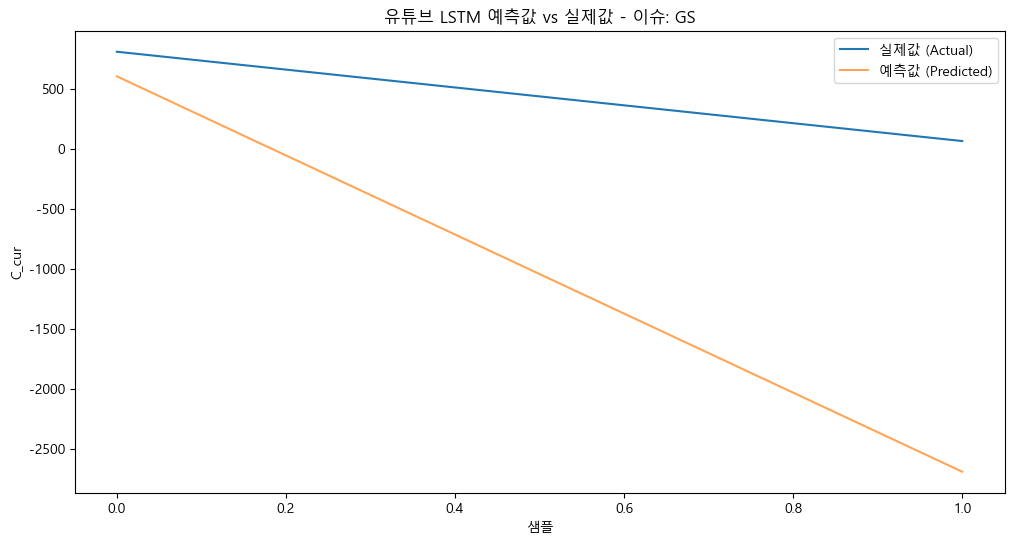

Epoch 1/40


c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0028
Epoch 2/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0028
Epoch 3/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0028
Epoch 4/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0023
Epoch 5/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0026
Epoch 6/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0023
Epoch 7/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0021
Epoch 8/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0019
Epoch 9/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0017
Epoch 10/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0020
Epoch 11/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0021
Epoch 12/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0019
Epoch 13/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0017
Epoch 14/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0018
Epoch 15/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0015    
Epoch 16/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1

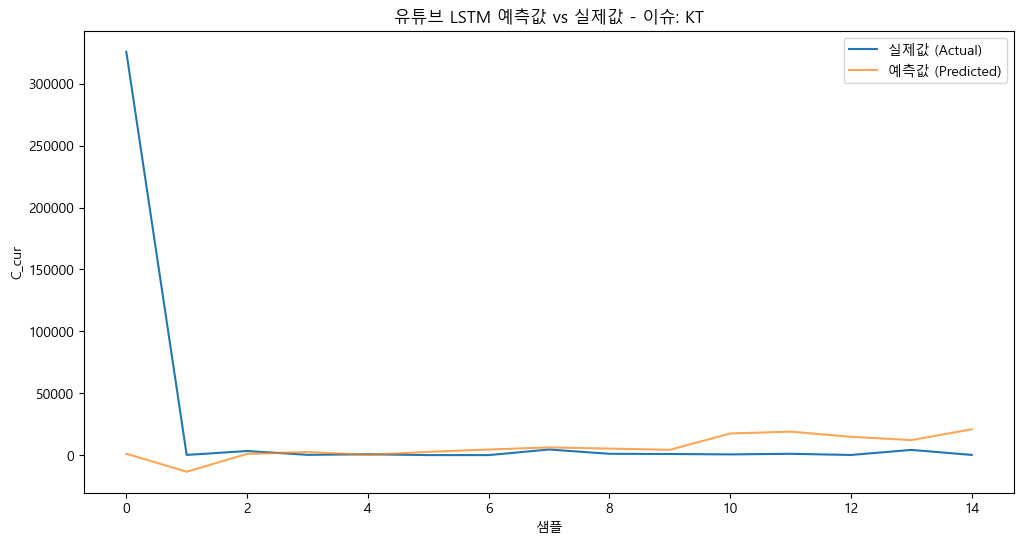

Epoch 1/40


c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0226
Epoch 2/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0205
Epoch 3/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0148 
Epoch 4/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0215 
Epoch 5/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0217
Epoch 6/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0179 
Epoch 7/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0183
Epoch 8/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0224
Epoch 9/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0151
Epoch 10/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0158
Epoch 11/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0132
Epoch 12/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0266
Epoch 13/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0163 
Epoch 14/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0148
Epoch 15/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0187
Epoch 16/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/st

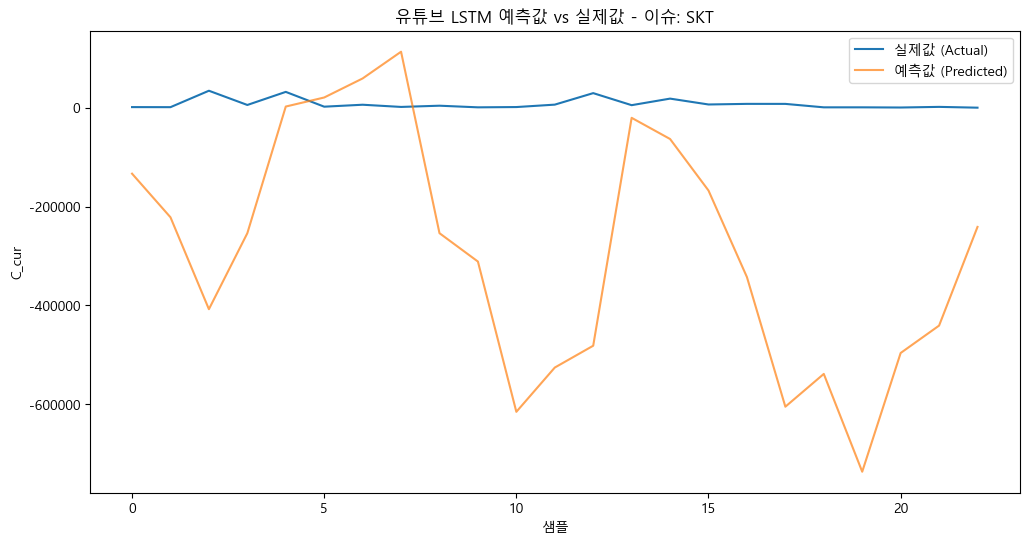

Epoch 1/40


c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0269
Epoch 2/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0242
Epoch 3/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0238
Epoch 4/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0230
Epoch 5/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0231
Epoch 6/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0140
Epoch 7/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0236
Epoch 8/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0129
Epoch 9/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0134
Epoch 10/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0226
Epoch 11/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0223
Epoch 12/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0132
Epoch 13/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0132
Epoch 14/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0223
Epoch 15/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0127
Epoch 16/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/

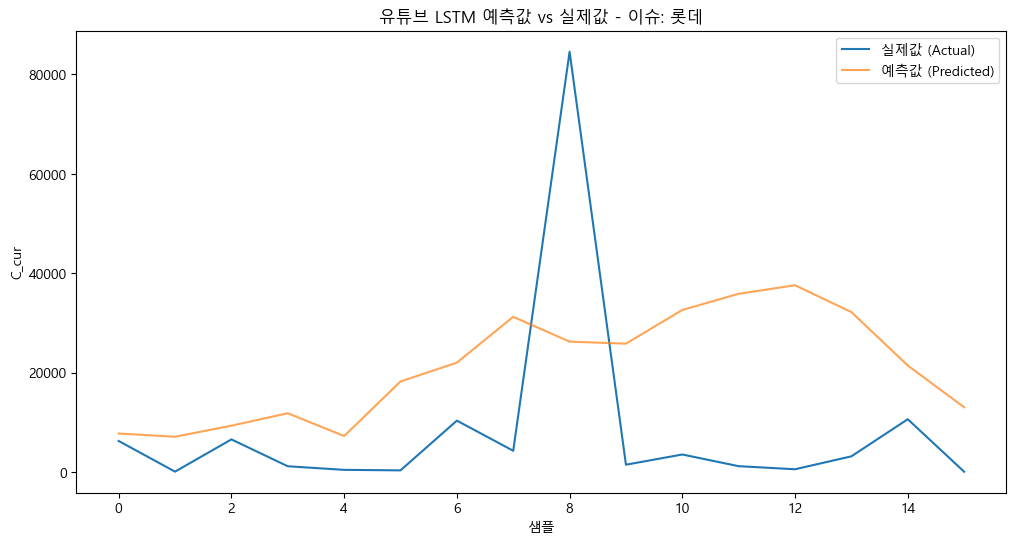

In [57]:

import matplotlib.pyplot as plt

# 유튜브 이슈 리스트 추출
youtube_issues = df[df['channel'] == '유튜브']['issue'].unique()

# 피처 리스트 정의
feature_cols = [
    'W','D','P','Lnorm',
    'Entity','Event','Impact','Reaction',
    'match_sum','comment_cnt','count',
    'viewCount','likeCount'
]

plt.rcParams['font.family'] = 'Malgun Gothic'  # 한글 폰트 설정 (윈도우)
plt.rcParams['axes.unicode_minus'] = False     # 음수 깨짐 방지

# 이슈별로 예측값과 실제값 시각화
for issue in youtube_issues:
    df_issue = df[(df['channel'] == '유튜브') & (df['issue'] == issue)]
    if len(df_issue) < 7:  # window=6 기준 최소 데이터 수 검사
        continue

    model, y_test_scaled, y_pred_scaled, Xscaler, yscaler = run_lstm_scaled(
        df_issue, feature_cols, target_col='C_cur', window=6
    )
    # 역스케일링
    y_test_inv = yscaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
    y_pred_inv = yscaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    plt.figure(figsize=(12,6))
    plt.plot(y_test_inv, label="실제값 (Actual)")
    plt.plot(y_pred_inv, label="예측값 (Predicted)", alpha=0.7)
    plt.title(f"유튜브 LSTM 예측값 vs 실제값 - 이슈: {issue}")
    plt.xlabel("샘플")
    plt.ylabel("C_cur")
    plt.legend()
    plt.show()



Epoch 1/40


c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0465
Epoch 2/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0238
Epoch 3/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0317
Epoch 4/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0321
Epoch 5/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0311
Epoch 6/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0319
Epoch 7/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0307
Epoch 8/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0314
Epoch 9/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0312
Epoch 10/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0310
Epoch 11/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0308
Epoch 12/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0309
Epoch 13/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0311
Epoch 14/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0313
Epoch 15/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0315
Epoch 16/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/

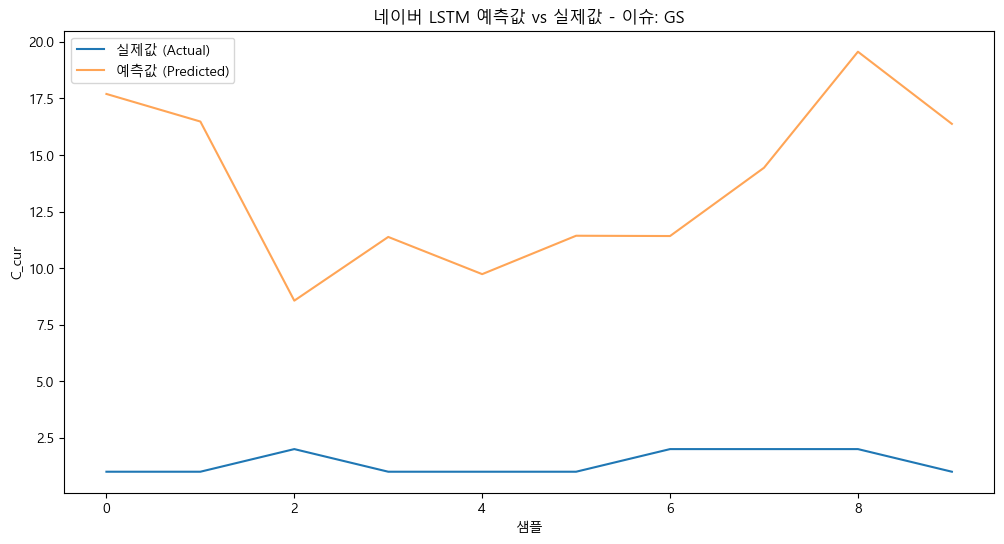

Epoch 1/40


c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0377
Epoch 2/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0216
Epoch 3/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0242
Epoch 4/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0194 
Epoch 5/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0299 
Epoch 6/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0267 
Epoch 7/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0185 
Epoch 8/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0232 
Epoch 9/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0293 
Epoch 10/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0151 
Epoch 11/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0225
Epoch 12/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0153 
Epoch 13/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0217 
Epoch 14/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0146 
Epoch 15/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0133 
Epoch 16/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/st

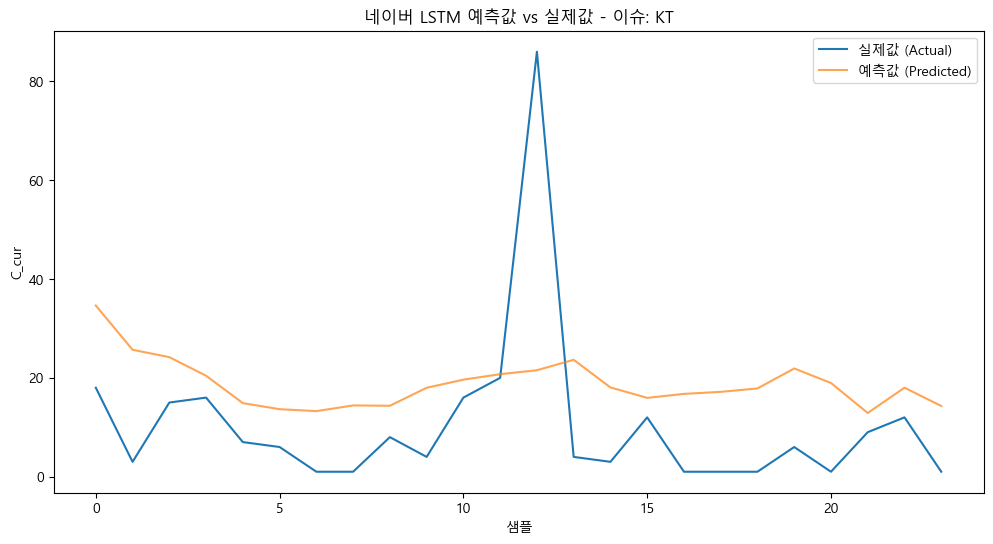

Epoch 1/40


c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0196
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0155 
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0117 
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0121 
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0220 
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0193 
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0133 
Epoch 8/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0178 
Epoch 9/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0172 
Epoch 10/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0198 
Epoch 11/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0160 
Epoch 12/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0118 
Epoch 13/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0135 
Epoch 14/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0128 
Epoch 15/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0130 
Epoch 16/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/st

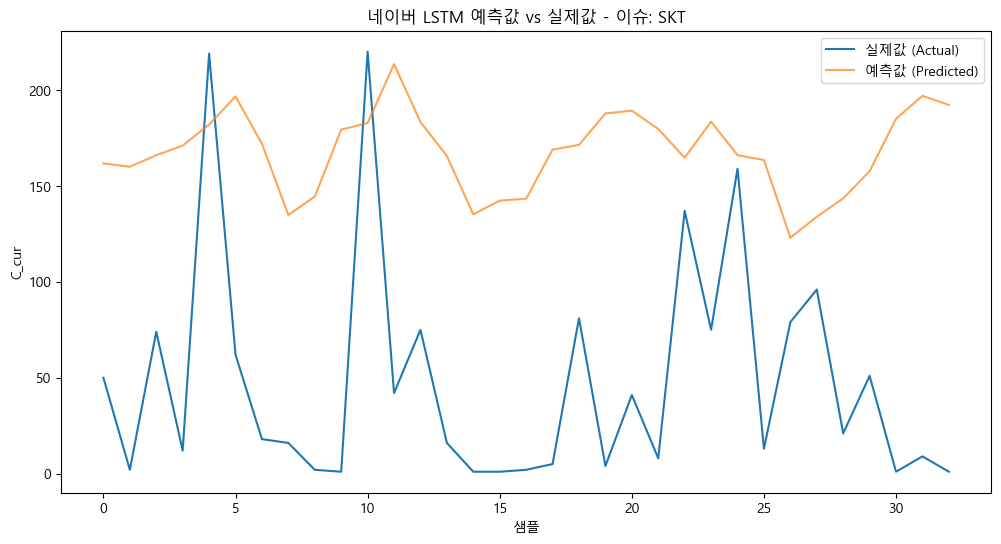

Epoch 1/40


c:\Users\speec\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0198
Epoch 2/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0027
Epoch 3/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010 
Epoch 4/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.7791e-04
Epoch 5/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.3353e-04 
Epoch 6/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.4381e-04 
Epoch 7/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.4128e-04
Epoch 8/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.9673e-04 
Epoch 9/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.9547e-04 
Epoch 10/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.7917e-04 
Epoch 11/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.9356e-04
Epoch 12/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.0058e-04 
Epoch 13/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.6038e-04 
Epoch 14/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.3220e-04 
Epoch 15/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.1772e-0

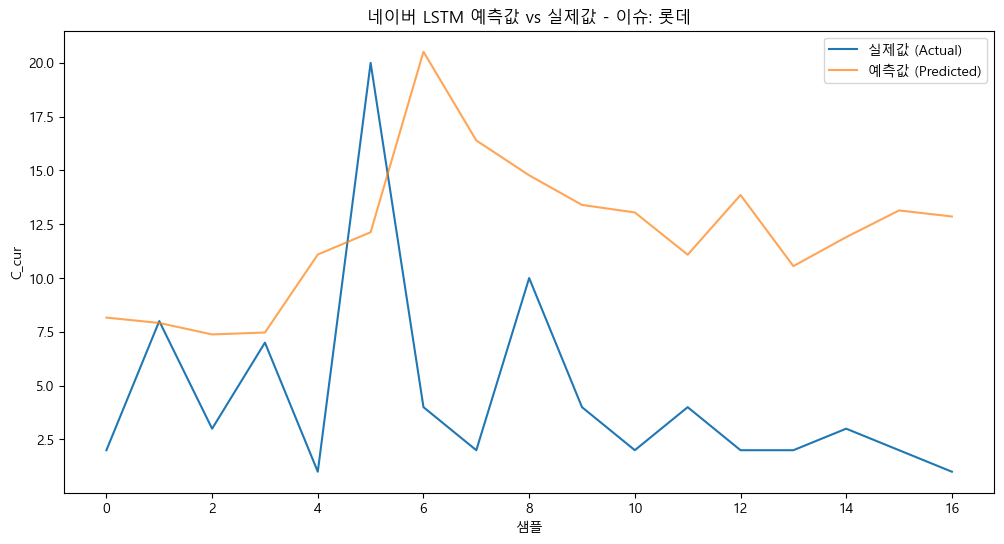

In [56]:
import matplotlib.pyplot as plt

# 이슈별로 네이버 데이터 시각화
issue_list = df[df['channel']=='네이버']['issue'].unique()

feature_cols = [
    'W','D','P','Lnorm',
    'Entity','Event','Impact','Reaction',
    'match_sum','comment_cnt','count',
    'viewCount','likeCount'
]

plt.rcParams['font.family'] = 'Malgun Gothic'  # 또는 'AppleGothic'(Mac), 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False     # 음수(-) 제대로 보이게

for issue in issue_list:
    df_issue = df[(df['channel']=='네이버') & (df['issue'] == issue)]
    if len(df_issue) < 7:  # window=6이므로 최소 7개 이상 필요
        continue

    model, y_test_scaled, y_pred_scaled, Xscaler, yscaler = run_lstm_scaled(
        df_issue, feature_cols, target_col='C_cur', window=6
    )
    y_test_inv = yscaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
    y_pred_inv = yscaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    plt.figure(figsize=(12,6))
    plt.plot(y_test_inv, label="실제값 (Actual)")
    plt.plot(y_pred_inv, label="예측값 (Predicted)", alpha=0.7)
    plt.title(f"네이버 LSTM 예측값 vs 실제값 - 이슈: {issue}")
    plt.xlabel("샘플")
    plt.ylabel("C_cur")
    plt.legend()
    plt.show()
